## TTCT Figural Image Registration

While MOTES Figural will likely not include a paper component, for piloting with TTCT data, we need to extract images of the test responses. First step is image registration, which essentially aligns two images. The intent is to scale and warp each test page to so that they can all be cropped identically.

In [10]:
from pathlib import Path
from pdf2image import convert_from_path
import cv2
from PIL import Image
import numpy as np
import pandas as pd
meta = pd.read_csv('../data/booklet-meta-full.csv', index_col=0)

Code from: https://learnopencv.com/image-alignment-feature-based-using-opencv-c-python/

Other resources:
- https://pyimagesearch.com/2020/08/31/image-alignment-and-registration-with-opencv/

In [15]:
sample = meta.query('booklet == "BOOKLETA"').sample(2)
sample[['path', 'titlepage']]

,path,titlepage
318,../data/ttct_figural/Unmatched/Booklets/FS11 P...,1
448,../data/ttct_figural/Unmatched/Booklets/FSII P...,1


In [97]:
im1p = convert_from_path(sample.iloc[0].path, 100, first_page=2, last_page=2, grayscale=False)[0]
im2p = convert_from_path(sample.iloc[1].path, 100, first_page=2, last_page=2, grayscale=False)[0]

In [98]:
np.array(im1p).ndim

3

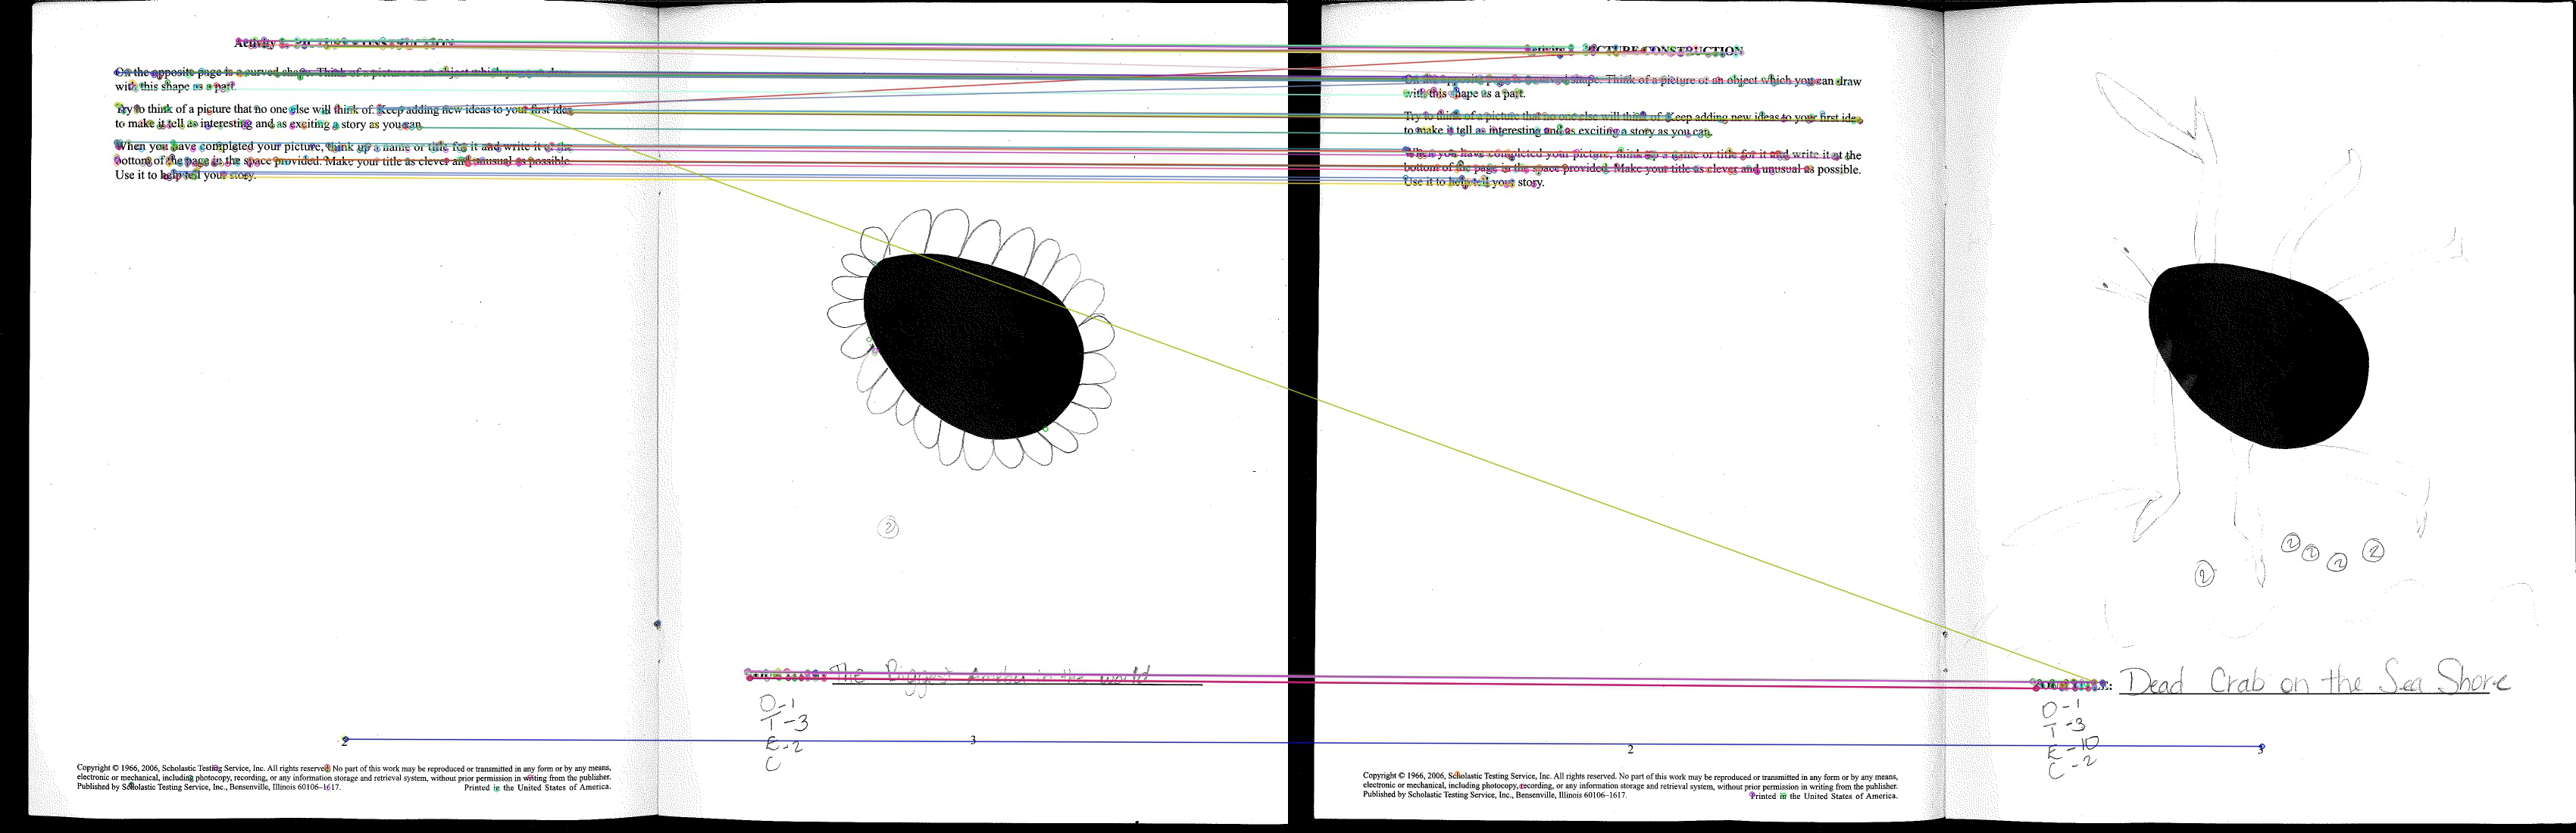

In [107]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

def alignImages(source, target, max_features=500, good_match_percent=.15, save_matches=False):
    ''' `source` image is the one that will be aligned, to target `target` image'''

    if type(source) is PIL.PpmImagePlugin.PpmImageFile:
        source = np.array(source)
    if type(target) is PIL.PpmImagePlugin.PpmImageFile:
        target = np.array(target)

    # Convert images to grayscale
    if source.ndim == 3:
        source = cv2.cvtColor(source, cv2.COLOR_BGR2GRAY)
    if target.ndim == 3:
        target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(max_features)
    keypoints1, descriptors1 = orb.detectAndCompute(source, None)
    keypoints2, descriptors2 = orb.detectAndCompute(target, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    matches = list(matches)
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * good_match_percent)
    matches = matches[:numGoodMatches]

    if save_matches:
        imMatches = cv2.drawMatches(source, keypoints1, target, keypoints2, matches, None)
        cv2.imwrite("../data/matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width = target.shape[:2]
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h

im1reg, h = alignImages(im1p, im2p, save_matches=True)
Image.open('../data/matches.jpg')

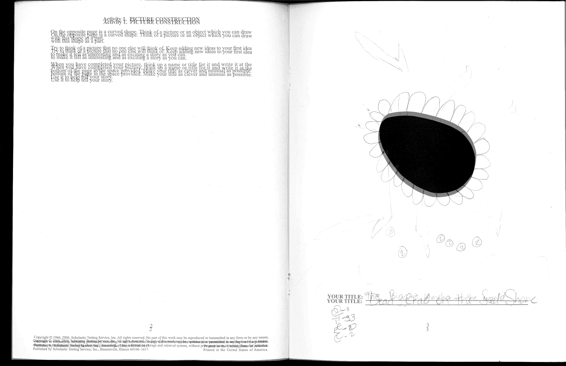

In [108]:
mask = Image.new("L", im1p.size, 128)
im_comp = Image.composite(im1p, im2p, mask)
w,h=im_comp.size
im_comp.resize((w//3,h//3))

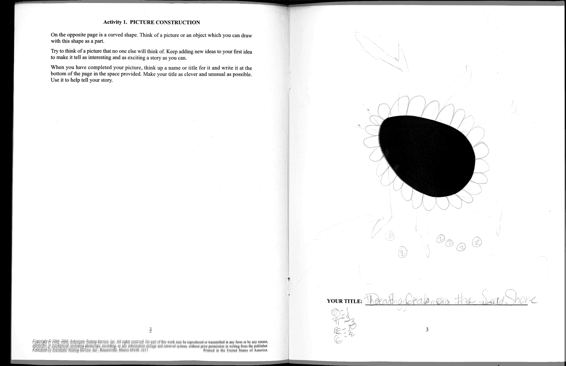

In [109]:
mask = Image.new("L", im1p.size, 128)
im1Regp = Image.fromarray(im1reg)
im_comp = Image.composite(im1Regp, im2p, mask)
w,h=im_comp.size
im_comp.resize((w//3,h//3))